# Finding Contours

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

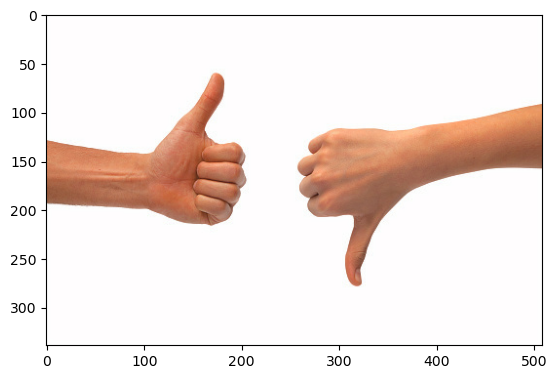

In [2]:
# Read in the image
image = cv2.imread('images/thumbs_up_down.jpg')

# Change color from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image);

### Produce binary image for finding contours

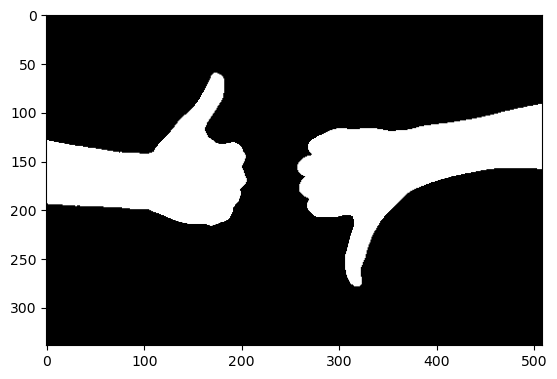

In [3]:
# Convert to grayscale
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Create a binary thresholded image
retval, binary = cv2.threshold(gray, 225, 255, cv2.THRESH_BINARY_INV)

plt.imshow(binary, cmap='gray')

### Find and draw the contours

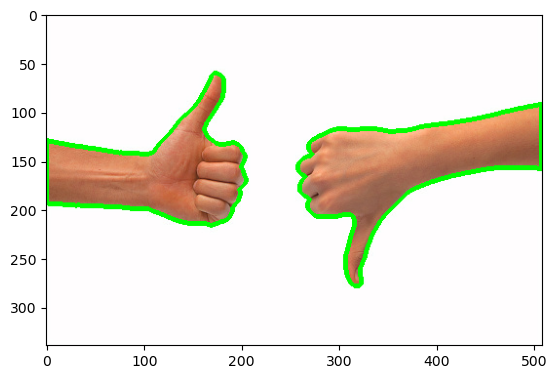

In [4]:
# Find contours from thresholded, binary image
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw all contours on a copy of the original image
contours_image = np.copy(image)
contours_image = cv2.drawContours(contours_image, contours, -1, (0,255,0), 3)

plt.imshow(contours_image)

Each detected contour can be characterized through a set of geometric and shape-related descriptors. Commonly computed features include the contour area, perimeter (arc length), and orientation, which describes the dominant direction along which the contour extends. 

In the following cell, the orientations of the left and right hand contours are to be estimated. The orientation information can be used to infer the overall pose of each hand, providing a practical cue for distinguishing between gestures such as a raised thumb versus a downward-pointing thumb.

### Orientation

The orientation of an object describes the general direction in which its shape is pointing within an image. For a contour, this direction can be estimated by fitting an ellipse around the contour points and using the angle of that ellipse.

Intuitively, the fitted ellipse acts like a smooth, simplified outline of the contour. Even if the contour itself is irregular, the ellipse captures its overall direction. By looking at the angle of this ellipse relative to the x-axis, it becomes easier to understand whether the object is mostly horizontal, vertical, or somewhere in between.

```python
# Fit an ellipse to a contour and extract the angle from that ellipse
(x,y), (MA,ma), angle = cv2.fitEllipse(selected_contour)
```

**Interpretation of orientation values**

The resulting orientation values are expressed in degrees relative to the x-axis. An angle of 0° corresponds to a contour aligned horizontally, while an angle of 90° indicates a contour oriented vertically upward.

Accordingly, the orientation angles computed for each contour can be used to reason about the overall pose of the hand. A hand with the thumb pointing upward is expected to exhibit a larger orientation angle (closer to 90°) compared to a hand with the thumb pointing downward, whose dominant direction is closer to horizontal.

### Find the orientation of each contour

In [7]:
# This function returns the orientations of a list of contours
# The list should be in the same order as the contours
# i.e. the first angle should be the orientation of the first contour
def orientations(contours):
    """
    Orientation:
    param contours: a list of contours
    return: angles, the orientations of the contours
    """

    # Create an empty list to store the angles in 
    angles = []

    for cnt in contours:
        # Fit an ellipse to a contour and extract the angle from that ellipse
        (x, y), (MA, ma), angle = cv2.fitEllipse(cnt)
        angles.append(angle)

    return angles

In [8]:
# Print out the orientation values
angles = orientations(contours)
print('Angles of each contour (in degrees): ' + str(angles))

Angles of each contour (in degrees): [61.35833740234375, 82.27550506591797]


### Bounding Rectangle
In the following step, a bounding rectangle is computed around the contour corresponding to the left hand, which is assumed to have its thumb pointing upward. This rectangle defines the smallest axis-aligned region that fully encloses the selected contour. By focusing on this region, irrelevant background information can be removed, allowing attention to be directed to a single hand.

```python
# Find the bounding rectangle of a selected contour
x,y,w,h = cv2.boundingRect(selected_contour)

# Draw the bounding rectangle as a purple box
box_image = cv2.rectangle(contours_image, (x,y), (x+w,y+h), (200,0,200),2)
```

The bounding rectangle can be thought of as a tight frame placed around the contour. Instead of analyzing the entire image, this frame isolates the area where the object of interest appears, which often simplifies visualization and further processing steps.

Once the bounding rectangle coordinates are obtained, the image can be cropped using the rectangle’s width and height. This operation extracts only the region inside the rectangle.

And to crop the image, select the correct width and height of the image to include.

```python
# Crop using the dimensions of the bounding rectangle (x, y, w, h)
cropped_image = image[y: y + h, x: x + w] 
```


In [10]:
# Below function returns a new, cropped version of the original image
def left_hand_crop(image, selected_contour):
    """
    Left hand crop:
    param image: the original image
    param selectec_contour: the contour that will be used for cropping
    return: cropped_image, the cropped image around the left hand
    """

    # Detect the bounding rectangle of the left hand contour
    # Crop the image using the dimensions of the bounding rectangle 
    # Make a copy of the image to crop
    cropped_image = np.copy(image)

    # Find the bounding rectangle of the selected contour
    x,y,w,h = cv2.boundingRect(selected_contour)

    # Crop the image using the dimensions of the bounding rectangle
    cropped_image = cropped_image[y: y + h, x: x + w]

    return cropped_image

In [11]:
# Select the left hand contour from the list
# Replace this value
selected_contour = contours[1]

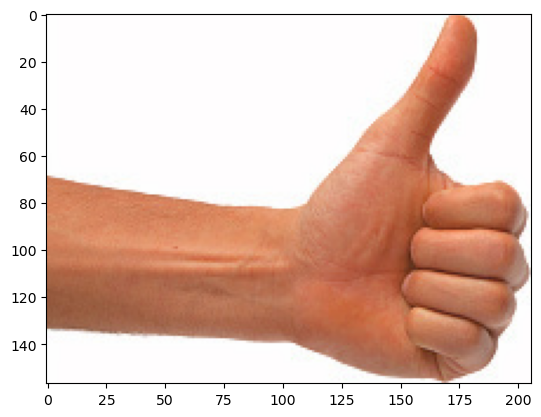

In [12]:
if(selected_contour is not None):
    # Call the crop function with that contour passed in as a parameter
    cropped_image = left_hand_crop(image, selected_contour)
    plt.imshow(cropped_image)